# Analyzing LLM circuits with transcoders!

This notebook will show you how you can use transcoders in order to interpretably analyze circuits in large language models.

# Setup

First, install required packages and download the transcoders.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# install the rest of our repository if we're running as a colab notebook
if IN_COLAB:
    ! git clone https://github.com/jacobdunefsky/transcoder_circuits.git
    ! mv transcoder_circuits transcoder_circuits_tmp
    ! mv transcoder_circuits_tmp/* . 

# install packages and download transcoders
! bash setup.sh  

Next, import the circuit analysis code.

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

/root/workspace/gnovack/repos/transcoder_circuits/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now, import the SAE/transcoder code, along with the model that we'll be analyzing (GPT2-small).

In [2]:
import os 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
torch.set_default_device(f"cuda:0")

from gpt_oss.model import HookedGptOssForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer
from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils

# model = AutoModelForCausalLM.from_pretrained('openai/gpt-oss-20b')
model = HookedGptOssForCausalLM.from_pretrained('openai/gpt-oss-20b')
# model.tokenizer = AutoTokenizer.from_pretrained('openai/gpt-oss-20b')
model.eval()
model.requires_grad_(False)
model.to('cuda:0')

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


HookedGptOssForCausalLM(
  (model): HookedGptOssModel(
    (embed_tokens): Embedding(201088, 2880, padding_idx=199999)
    (layers): ModuleList(
      (0-23): 24 x HookedGptOssDecoderLayer(
        (self_attn): GptOssAttention(
          (q_proj): Linear(in_features=2880, out_features=4096, bias=True)
          (k_proj): Linear(in_features=2880, out_features=512, bias=True)
          (v_proj): Linear(in_features=2880, out_features=512, bias=True)
          (o_proj): Linear(in_features=4096, out_features=2880, bias=True)
        )
        (mlp): HookedGptOssMlp(
          (router): GptOssTopKRouter()
          (experts): Mxfp4GptOssExperts()
        )
        (input_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
        (post_attention_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
      )
    )
    (norm): GptOssRMSNorm((2880,), eps=1e-05)
    (rotary_emb): GptOssRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2880, out_features=201088, bias=False)
)

Now, load in a corpus of text that we'll use for our analysis. We'll be drawing from OpenWebText, which is similar to the dataset on which GPT2-small was trained.

In [3]:
model.model.layers[1].OV(0).shape

torch.Size([2880, 2880])

In [4]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
from datasets import load_dataset
from huggingface_hub import HfApi
import numpy as np

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=1_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(2048*16)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).to('cuda:0')

# Basic transcoder investigation

First, let's load all of our transcoders (one for each layer of GPT2-small except for the last one)

In [7]:
# transcoder_template = "./gpt-oss-20b-transcoders/rb3fw33t/20000768_sparse_autoencoder_openai/gpt-oss-20b_mlp_input.{}_92160"
transcoder_template = "./v0-gpt-oss-20b-transcoders/gpt-oss-20b_mlp_input.{}_92160"
transcoders = []
frequencies = []
for i in range(8):
    print(f"loading transcoder {i}...")
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    frequencies.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

loading transcoder 0...
loading transcoder 1...
loading transcoder 2...
loading transcoder 3...
loading transcoder 4...
loading transcoder 5...
loading transcoder 6...
loading transcoder 7...


In [8]:
# Clean up memory
import gc
gc.collect()
torch.cuda.empty_cache()

## Get live features for the Layer 8 transcoder

In this notebook, we'll be using the Layer 8 transcoder in particular during our examples. (This layer was just chosen because it's decently late enough in the network that it should capture some abstract concepts that might be interesting.)

The first step is to get the set of live features in this transcoder. (Live features are defined as features that fire more than once every 10k tokens.)

In [9]:
utils.to_numpy(frequencies[4]).max()

-0.29347348

In [10]:
frequencies

[tensor([-4.2321, -5.1500, -3.1305,  ..., -5.1352, -6.6122, -4.3975]),
 tensor([-6.0103, -4.2641, -3.7098,  ..., -4.7611, -5.1072, -4.7863]),
 tensor([-6.6122, -3.1870, -4.5953,  ..., -4.7928, -4.3135, -3.9964]),
 tensor([-6.3112, -4.9222, -6.1352,  ..., -4.4028, -3.6610, -3.2523]),
 tensor([-4.0965, -3.0210, -3.6346,  ..., -4.5871, -4.6124, -2.4642]),
 tensor([-5.1652, -2.7111, -4.0621,  ..., -4.8062, -4.4421, -6.6122]),
 tensor([-1.9011, -4.8489, -3.5718,  ..., -2.7098, -6.1352, -4.0453]),
 tensor([-2.8670, -3.2195, -3.4546,  ..., -4.4480, -3.1064, -6.6122])]

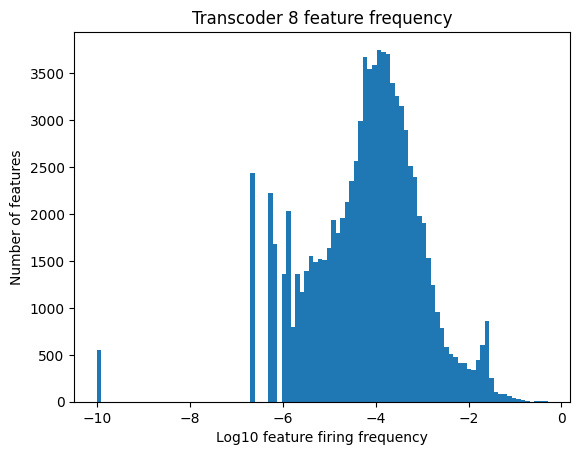

In [11]:
plt.hist(utils.to_numpy(frequencies[4]), bins=100)
plt.xlabel("Log10 feature firing frequency")
plt.ylabel("Number of features")
plt.title("Transcoder 8 feature frequency")
plt.show()

In [12]:
live_features = np.arange(len(frequencies[0]))[utils.to_numpy(frequencies[0] > -4)]

## Top activating examples for a feature

What examples cause a given transcoder feature to activate most strongly? Let's look at the zeroth live transcoder feature for our layer 8 transcoder.

In [44]:
owt_tokens_torch.shape

torch.Size([32768, 128])

In [47]:
feature_idx = 34885 # get zeroth live feature
# feature_idx = live_features[101] # get zeroth live feature

# get feature activation scores
scores = get_feature_scores(model, transcoders[4], owt_tokens_torch, feature_idx, batch_size=128)
# what's happening in the above line of code?
# owt_tokens_torch: our dataset of OpenWebText tokens
# batch_size: how many inputs to process at once

# display top activating examples
display_activating_examples_dash(model, owt_tokens_torch, scores)

100%|██████████| 256/256 [02:00<00:00,  2.12it/s]


You can also use `get_feature_scores()` on an individual prompt.

In [ ]:
print(get_feature_scores(model, transcoders[0], model.tokenizer(
    "This was the defenseman's first championship win",
return_tensors='pt').input_ids, feature_idx))

print(get_feature_scores(model, transcoders[0], model.tokenizer(
    "This was the rookie's first goal of the season",
return_tensors='pt').input_ids, feature_idx))

print(get_feature_scores(model, transcoders[0], model.tokenizer(
    "After last night's game, the State Department has finally gotten their first",
return_tensors='pt').input_ids, feature_idx))

In [ ]:
_, cache = model.run_with_cache("Hello, world!") # "model" is a HookedTransformer from TransformerLens
activations = cache[transcoders[8].cfg.hook_point] # transcoders[8].cfg.hook_point tells us where transcoders[8] gets its input from
feature_activations = transcoders[8](activations)[1]
feature_activations = feature_activations[0,-1] # batch 0, last token
torch.topk(feature_activations, k=5) # what are the top features activated on the last token?

## An aside: Jacob's interpretations of the first 30 live features

For the purposes of evaluating transcoder interpretability, I (Jacob) went through the first 30 live features and tried to interpret them. My (somewhat terse) notes on each feature can be found below. If you're a fan of replicating work, feel free to use feature dashboards to interpret these features yourself and see if you end up finding the same patterns.

* 0: possessive pronoun + "first" (particularly in context of sports)
* 1: " goal" (in context of sports)
* 2: passive verbs: " was awarded", " has been promised", " were denied" -- particularly this "awarded"/"promised"/"offered"/"refused"/"denied" semantic field (related to authority?)
* 3: "You see" (highest at beginning of sentence, lower when in a little "parenthetical" like "blah blah, you see, is a blah")
* 4: activates on the "the" in "against the" (and is then followed by sports team name)
* 5: "doesn"/"wouldn"/"don" (highest are forms of "said that he doesn't")
* 6: activates on text in closed brackets (highest ones are `[image via screengrab]` and `[link]` and `[youtube]`)
* 7: Period **single token feature**
* 8: forms of the verb "pull" (lower-scoring examples include related verbs like "draws his firearm" or "backing away")
* 9: Period in the context of politics?
* 10: **single token** ` at` feature?
* 11: top examples are "speaking on", lower ones include "an interview on"
* 12: " The" after period in the context of political/financial reports? **broader context is iffy**
* 13: local context feature for sports titles and trophies (e.g. "named the recipient for the WHL's")
* 14: forms of the verb "challenge"
* 15: " with" after comma (and in lower examples, period) when punctuation is preceded by noun
* 16: Tokenization feature: single letter at beginning of place name (e.g. " Arab border town of **R**abiya", " southern city of **W**uerzberg")
* 17: **uninterpretable local context feature** (the first uninterpretable one so far!)
* 18: it "is"/"seems"/"would be" unwise/improper/ridiculous
* 19: forms of verb "count" (always when used as verb)
* 20: "Cost" and "cost" **single token feature**
* 21: forms of verb "fight"
* 22: " with" after verbs and adjectives that routinely take "with" as a complement -- e.g. fires on "giddy with anticipation" and "filled with joy" but not "I ate with him last week"
* 23: prepositions after verbs, particularly past-tense verbs (e.g. "cases heard **in** an appropriate manner", "images posted **by**", "journals posted **in** full"
* 24: weird tokenization feature: beginning of words like **sur**prised (after unicode quotes), **bel**ieves (after unicode quotes), **Tr**aded
* 25: "Hay" **single token feature**
* 26: verb + " the same" + abstract noun ("question", "procedure", "approach", "system", "thing")
* 27: tokenization at end of names in context of media?
* 28: "general", as adjective
* 29: **interesting one**: local context feature about having the BLANK and BLANK needed to succeed (e.g. "I didn't have the **courage**", "without the **information and skills that** they need", "lack the **capacity and expertise** needed")

Summary stats:
* 5/30 features were single-token features without any further interpretable pattern
  * Example of a further pattern: "general" as adjective, or "with" after verbs/adjectives that regularly take "with" as a complement 
* Only 1/30 features was uninterpretable
* 4/30 features fired on different forms of a single verb

# Replacing MLPs with transcoders

One way to evaluate the fidelity of a transcoder is to replace the corresponding MLP sublayer in the model with the transcoder, run the model with the replaced sublayer, and see how this affects the output.

We make this easy by providing a context manager: `TranscoderReplacementContext`. Here, we'll use it to see how the zeroth live feature for the layer 8 transcoder changes its activation depending on whether or not earlier layers' MLPs were replaced by transcoders.

In [ ]:
prompt = "After last night's game, the Cubs have finally gotten their first"

scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, live_features[0])
print("Original feature activations:")
print(f"\t{scores}")
with TranscoderReplacementContext(model, transcoders[1:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, live_features[0])
print("Replace all MLP layers after MLP0 until MLP8 with transcoders:")
print(f"\t{scores}")

with TranscoderReplacementContext(model, transcoders[:8]):
    scores = get_feature_scores(model, transcoders[8], model.tokenizer(prompt, return_tensors='pt').input_ids, live_features[0])
print("Replace all MLP layers up to MLP8 with transcoders:")
print(f"\t{scores}")

Looks like our Layer 0 transcoder fails to capture some important properties of MLP0 that cause the layer 8 feature to activate: the activation score noticeably drops when MLP0 is replaced.

Note that the `TranscoderReplacementContext` automatically knows which MLP sublayers need to be replaced with each transcoder. All you have to do is just pass in a list of transcoders that you want to replace.

## Evaluating transcoder performance

This approach can also be used to evaluate the fidelity of a transcoder in its approximation of the original MLP sublayer. Here's how:

1. Run the original model on some dataset and compute the mean cross entropy loss of the model on the dataset.
2. Replace an MLP sublayer (or many!) with a transcoder (or many!), and rerun the model on this dataset, computing the mean cross entropy loss.
3. Compare the original model loss to the loss of the transcoder-replaced model.
4. (As another baseline, you can zero-ablate the MLP sublayer (i.e. replace its output with the zero vector) or mean-ablate it (i.e. first cache the mean output vector of the MLP sublayer on the dataset, and then re-run the model on the dataset replacing the MLP sublayer with its mean output) and record the cross entropy loss on the dataset. Zero-ablation is made easy by the `ZeroAblationContext` context manager, which takes a list of layers to zero-ablate.)

This is demonstrated in the below function. **Warning: running it will take a while!**

In [ ]:
def eval_transcoders_cross_entropy(model, all_tokens, transcoders, num_batches=100, batch_size=128, only_get_transcoder_loss=False):
    original_losses = []
    transcoder_losses = []
    zero_ablated_losses = []

    # get a list of layers associated with each transcoder
    layers = [t.cfg.hook_point_layer for t in transcoders]
    
    with torch.no_grad():
        for batch in tqdm.tqdm(range(0, num_batches)):
            cur_batch_tokens = all_tokens[batch*batch_size:(batch+1)*batch_size]

            if not only_get_transcoder_loss:
                original_losses.append(utils.to_numpy(model(cur_batch_tokens, labels=cur_batch_tokens, return_type="loss").loss))

            with TranscoderReplacementContext(model, transcoders):
                transcoder_losses.append(utils.to_numpy(model(cur_batch_tokens, labels=cur_batch_tokens, return_type="loss").loss))

            if not only_get_transcoder_loss:
                with ZeroAblationContext(model, layers):
                    zero_ablated_losses.append(utils.to_numpy(model(cur_batch_tokens, labels=cur_batch_tokens, return_type="loss").loss))

    return {
        'original_losses': np.mean(original_losses),
        'transcoder_losses': np.mean(transcoder_losses),
        'zero_ablated_losses': np.mean(zero_ablated_losses)
    }

In [ ]:
# what is the model loss when we replace *all* MLPs with transcoders?
all_transcoders_losses = eval_transcoders_cross_entropy(model, owt_tokens_torch, transcoders[5:8], num_batches=4)
print(all_transcoders_losses)

In [ ]:
# what is the loss when we replace all MLPs with transcoders *except for MLP0 and MLP11*?
some_transcoders_losses = eval_transcoders_cross_entropy(model, owt_tokens_torch, transcoders[1:-1], only_get_transcoder_loss=True)
print(some_transcoders_losses)

Alright. For reference, our original model's cross-entropy loss on this dataset is 3.59 nats. When we zero-ablate all the MLP sublayers, then the cross-entropy loss jumps to 10.94 nats. When we replace all the MLPs with transcoders, the loss is 4.23 nats, and when we don't replace MLP0 and MLP11 with transcoders, the loss is 4.06 nats.

We can also evaluate the transcoders by looking at the mean KL divergence of the original model's outputs from the transcoder-replaced model's outputs.

In [ ]:
def eval_transcoders_kl_div(model, all_tokens, transcoders, num_batches=400, batch_size=32):
    kls = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(range(0, num_batches)):
            cur_batch_tokens = all_tokens[batch*batch_size:(batch+1)*batch_size]
            real_logits = model(cur_batch_tokens, return_type="logits")
            real_logits = real_logits.reshape(-1, real_logits.shape[-1])
            real_softmax = torch.nn.functional.log_softmax(real_logits, dim=-1)
            with TranscoderReplacementContext(model, transcoders):
                tc_logits = model(cur_batch_tokens, return_type="logits")
                tc_logits = tc_logits.reshape(-1, tc_logits.shape[-1])
                tc_softmax = torch.nn.functional.log_softmax(tc_logits, dim=-1)
            kls.append(torch.nn.functional.kl_div(tc_softmax, real_softmax, reduction='batchmean', log_target=True).item())

    return np.mean(kls)

In [ ]:
eval_transcoders_kl_div(model, owt_tokens_torch, transcoders)

Not bad: when we replace all MLP sublayers with transcoders, the mean KL divergence of the transcoder-replaced model outputs from the actual model outputs is only 0.668 nats.

# Circuit analysis walkthrough

Now, let's learn how to analyze circuits with transcoders! We'll be looking at a random transcoder feature in Layer 8, and trying to analyze the circuits that determines whether or not this feature fires. In effect, we're reverse-engineering the transcoder feature.

First, let's look at the top activating examples for this feature.

In [13]:
feature_idx = live_features[182] # choose the 77th live feature, because lucky number 7
scores = get_feature_scores(model, transcoders[5], owt_tokens_torch[:128*20], feature_idx, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, scores)

100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


The pattern here seems to be "capital letters after numbers, particularly in the context of machines or weapons".

## Replace MLPs with transcoders

First, what parts of the computation do transcoders capture? We'll look at how the layer 8 feature activation changes based on whether or not we replace lower-layer MLPs with transcoders.

In [14]:
prompt = "I am going to the grocery store to buy eggs"
token_strs = model.to_str_tokens(prompt)
_, cache = model.run_with_cache(model.tokenizer(prompt, return_tensors='pt').input_ids)
scores = get_feature_scores(model, transcoders[5], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

[[0.     0.     0.     0.     0.     0.585  0.2983 0.     0.154  0.1073]]


In [15]:
# replace all MLPs up to layer 5 with transcoders
with TranscoderReplacementContext(model, transcoders[:5]):
    scores = get_feature_scores(model, transcoders[5], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

[[0.       0.       0.       0.       0.       0.415    0.1376   0.
  0.0173   0.003336]]


When we replace all the MLPs with transcoders, then the feature fires a lot less.

What about if we only replace MLPs starting at layer 1?

In [16]:
# replace all MLPs up to layer 8 with transcoders
with TranscoderReplacementContext(model, transcoders[1:5]):
    scores = get_feature_scores(model, transcoders[5], model.tokenizer(prompt, return_tensors='pt').input_ids, feature_idx, batch_size=128, use_raw_scores=False)
print(scores)

100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

[[0.     0.     0.     0.     0.     0.4136 0.1225 0.     0.     0.    ]]


The feature gets closer to its original firing score. This makes sense: MLP0 in GPT2-small is thought to be particularly tricky to deal with, since it's viewed as an "extended token embedding".

## Feature vectors and computational paths

Let's get started doing some circuit analysis!

### Feature vectors

The first step is to create a `FeatureVector` object corresponding to the layer 8 transcoder feature that we want to analyze. We can easily do this using the `make_sae_feature_vector()` function (which works just as well for transcoders as SAEs):

In [17]:
feature_idx = live_features[182]
feature_vector = make_sae_feature_vector(transcoders[5], feature_idx, token=5)
print(feature_vector)

mlp5tc[701]@5


We now have a `FeatureVector` object with the representation `mlp8tc[89]@-1`. What does this mean?

* `mlp8` means that this is a feature vector associated with MLP8.
* `tc` means that this is a transcoder feature.
* `[89]` means that this is feature #89 in the transcoder (because the 77th live feature in the transcoder is feature #89).
* `@-1` means that this feature vector is associated with the `-1`th token -- that is to say, the final token -- in the prompt. Because our feature fires on the last token in the prompt, this is the one that we want to analyze. But if you wanted to analyze some other token -- say, token 5 -- then you could do so by writing `make_sae_feature_vector(transcoders[8], feature_idx, token=5)`.

Note that you can access the actual vector associated with any `FeatureVector` object with `feature_vector.vector`. In this case, `feature_vector.vector` is the encoder vector associated with the transcoder feature.

In [18]:
feature_vector.vector.shape

torch.Size([2880])

In [19]:
list(enumerate(token_strs))

[(0, 'I'),
 (1, ' am'),
 (2, ' going'),
 (3, ' to'),
 (4, ' the'),
 (5, ' grocery'),
 (6, ' store'),
 (7, ' to'),
 (8, ' buy'),
 (9, ' eggs')]

### Getting top computational paths

Now that we have a `FeatureVector` object, let's find the computational paths in the model that are most important for causing this feature vector to activate on this input. To do this, we'll use the function `greedy_get_top_paths()`.

In [20]:
cache.keys()

dict_keys(['value.0', 'residual.0', 'attn_pattern.0', 'mlp_input_pre_norm.0', 'mlp_input.0', 'mlp_output.0', 'value.1', 'residual.1', 'attn_pattern.1', 'mlp_input_pre_norm.1', 'mlp_input.1', 'mlp_output.1', 'value.2', 'residual.2', 'attn_pattern.2', 'mlp_input_pre_norm.2', 'mlp_input.2', 'mlp_output.2', 'value.3', 'residual.3', 'attn_pattern.3', 'mlp_input_pre_norm.3', 'mlp_input.3', 'mlp_output.3', 'value.4', 'residual.4', 'attn_pattern.4', 'mlp_input_pre_norm.4', 'mlp_input.4', 'mlp_output.4', 'value.5', 'residual.5', 'attn_pattern.5', 'mlp_input_pre_norm.5', 'mlp_input.5', 'mlp_output.5', 'value.6', 'residual.6', 'attn_pattern.6', 'mlp_input_pre_norm.6', 'mlp_input.6', 'mlp_output.6', 'value.7', 'residual.7', 'attn_pattern.7', 'mlp_input_pre_norm.7', 'mlp_input.7', 'mlp_output.7', 'value.8', 'residual.8', 'attn_pattern.8', 'mlp_input_pre_norm.8', 'mlp_input.8', 'mlp_output.8', 'value.9', 'residual.9', 'attn_pattern.9', 'mlp_input_pre_norm.9', 'mlp_input.9', 'mlp_output.9', 'value.10

In [21]:
prompt = "I am going to the grocery store to buy eggs"
_, cache = model.run_with_cache(model.tokenizer(prompt, return_tensors='pt').input_ids) # cache the model activations on this prompt

all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=3, num_branches=35, do_raw_attribution=True)

Here are the arguments that we passed to `greedy_get_top_paths()`, in order:
* `model` is the model that we're analyzing.
* `transcoders` is our list of transcoders.
* `cache` is the cache of model activations on our input.
* `feature_vector` is the FeatureVector object that we want to analyze.
* `num_iters` tells us how many times to iterate the greedy pathfinding algorithm. In effect, this is the length of the longest computational paths returned by `greedy_get_top_paths()`.
* `num_branches` tells us how many paths of each length we should look at.
* `do_raw_attribution=True` has to do with how computational path attributions (that is, how important each path is) are calculated. When `do_raw_attribution=False` is set, then attributions are calculated by seeing how much the output feature activation would change if a lower-layer feature is zero-ablated. In general, `do_raw_attribution=True` has better mathematical properties, so we'll use this.

What are our computational paths? Let's print them:

In [22]:
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp5tc[701]@5: 0.58 <- embed0@5: 2.8
Path [0][1]: mlp5tc[701]@5: 0.58 <- attn3[32]@5: 0.3
Path [0][2]: mlp5tc[701]@5: 0.58 <- attn4[18]@5: 0.28
Path [0][3]: mlp5tc[701]@5: 0.58 <- attn5[39]@5: 0.25
Path [0][4]: mlp5tc[701]@5: 0.58 <- attn4[38]@5: 0.22
Path [0][5]: mlp5tc[701]@5: 0.58 <- attn1[40]@5: 0.18
Path [0][6]: mlp5tc[701]@5: 0.58 <- attn5[59]@5: 0.17
Path [0][7]: mlp5tc[701]@5: 0.58 <- attn2[8]@5: 0.13
Path [0][8]: mlp5tc[701]@5: 0.58 <- attn0[53]@1: 0.12
Path [0][9]: mlp5tc[701]@5: 0.58 <- attn5[62]@5: 0.12
Path [0][10]: mlp5tc[701]@5: 0.58 <- attn5[7]@5: 0.11
Path [0][11]: mlp5tc[701]@5: 0.58 <- attn4[20]@5: 0.1
Path [0][12]: mlp5tc[701]@5: 0.58 <- mlp4tc[14761]@5: 0.09
Path [0][13]: mlp5tc[701]@5: 0.58 <- attn5[50]@5: 0.082
Path [0][14]: mlp5tc[701]@5: 0.58 <- attn3[63]@5: 0.075
Path [0][15]: mlp5tc[701]@5: 0.58 <- mlp4tc[82879]@5: 0.073
Path [0][16]: mlp5tc[701]@5: 0.58 <- attn3[61]@5: 0.073
Path [0][17]: mlp5tc[701]@5: 0.58 <- attn4[6]@5

That's a lot of output! Let's break down what the output for a single computational path looks like. As an example, let's focus on this line:

``Path [1][4]: mlp8tc[89]@-1: 7.6 <- attn2[2]@8: 0.35 <- mlp0tc[10490]@8: 0.17``

Here's what each part means:

* `Path [1][4]: ` means that you can access this computational path as `all_paths[1][4]`. Note that a computational path is just a list of `FeatureVector` objects.
* The rest of the line is a representation of the computational path. Importantly, later-layer features are at the left; earlier-layer features are at the right. As an example, the layer 8 feature `mlp8tc[89]@-1: 7.6` comes to the left of the layer 2 feature `attn2[2]@8: 0.35`. The left-pointing `<-` arrows serve to clarify this.
* We already discussed what `mlp8tc[89]@-1` means. But `mlp8tc[89]@-1: 7.6` means that this "root" feature has an activation of 7.6 on this input.
* The feature in the middle, `attn2[2]@8: 0.35`, is a feature vector associated with an *attention* sublayer. In particular:
  * `attn2` means that this feature is associated with layer 2 attention.
  * `[2]` means that this feature is associated with attention head 2.
  * `@8` means that the source token for this feature is token 8.
  * `: 0.35` means that this feature contributes 0.35 to the root feature's activation.
* Similarly, `mlp0tc[10490]@8: 0.17` means that the MLP0 transcoder feature 10490 contributes 0.17 to the root feature's activation from token 8.

### Filtering paths

Once you have a big list of computational paths, you can filter computational paths based on flexible rules, using `FeatureFilter` objects in conjunction with the `get_paths_via_filter()` function.

As an example, here's how you can filter for paths that don't go through the MLP2 transcoder, that don't end on token 9, and that do end on a layer 0 feature: 

In [23]:
# ignore paths that go through MLP2 transcoder
filtered_paths = get_paths_via_filter(all_paths, not_infix_path=[
    FeatureFilter(
        layer=2, layer_filter_type=FilterType.EQ,
        feature_type=FeatureType.TRANSCODER
    )
])

# ignore paths that end in last token
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=9, token_filter_type=FilterType.NE)
])

# look at paths that end in layer 0
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(layer=0)
])

print_all_paths(filtered_paths)

Path [0]: mlp5tc[701]@5: 0.58 <- embed0@5: 2.8
Path [1]: mlp5tc[701]@5: 0.58 <- attn0[53]@1: 0.12
Path [2]: mlp5tc[701]@5: 0.58 <- attn0[40]@4: 0.041
Path [3]: mlp5tc[701]@5: 0.58 <- attn5[39]@5: 0.25 <- embed0@5: 0.39
Path [4]: mlp5tc[701]@5: 0.58 <- mlp3tc[16905]@5: 0.057 <- embed0@5: 0.35
Path [5]: mlp5tc[701]@5: 0.58 <- mlp3tc[15666]@5: 0.052 <- embed0@5: 0.19
Path [6]: mlp5tc[701]@5: 0.58 <- mlp4tc[78723]@5: 0.062 <- embed0@5: 0.16
Path [7]: mlp5tc[701]@5: 0.58 <- mlp4tc[14761]@5: 0.09 <- embed0@5: 0.15
Path [8]: mlp5tc[701]@5: 0.58 <- attn2[8]@5: 0.13 <- embed0@5: 0.12
Path [9]: mlp5tc[701]@5: 0.58 <- attn5[50]@5: 0.082 <- embed0@5: 0.11
Path [10]: mlp5tc[701]@5: 0.58 <- mlp4tc[82879]@5: 0.073 <- embed0@5: 0.093
Path [11]: mlp5tc[701]@5: 0.58 <- attn5[32]@5: 0.057 <- embed0@5: 0.088
Path [12]: mlp5tc[701]@5: 0.58 <- attn5[62]@5: 0.12 <- embed0@5: 0.087
Path [13]: mlp5tc[701]@5: 0.58 <- attn5[7]@5: 0.11 <- embed0@5: 0.082
Path [14]: mlp5tc[701]@5: 0.58 <- attn3[42]@5: 0.051 <- emb

### Computational graphs

Once we have a list of computational paths, we can combine them all into a single computational graph:

In [24]:
edges, nodes = paths_to_graph(all_paths)

Each edge in the graph tells you the total contribution from one feature to another, across all computational paths in which the edge is present. Each node tells you the total contribution of the feature associated with the node across all computational paths.

Let's print out our edges:

In [25]:
for edge, contrib in edges.items():
    print(edge, contrib)

('embed0@5', 'mlp5tc[701]@5') 2.828918933868408
('attn3[32]@5', 'mlp5tc[701]@5') 0.3037740886211395
('attn4[18]@5', 'mlp5tc[701]@5') 0.27857744693756104
('attn5[39]@5', 'mlp5tc[701]@5') 0.24690142273902893
('attn4[38]@5', 'mlp5tc[701]@5') 0.21723195910453796
('attn1[40]@5', 'mlp5tc[701]@5') 0.18102377653121948
('attn5[59]@5', 'mlp5tc[701]@5') 0.16829350590705872
('attn2[8]@5', 'mlp5tc[701]@5') 0.13460716605186462
('attn0[53]@1', 'mlp5tc[701]@5') 0.11848708242177963
('attn5[62]@5', 'mlp5tc[701]@5') 0.1152217835187912
('attn5[7]@5', 'mlp5tc[701]@5') 0.10631431639194489
('attn4[20]@5', 'mlp5tc[701]@5') 0.09999728202819824
('mlp4tc[14761]@5', 'mlp5tc[701]@5') 0.0896139144897461
('attn5[50]@5', 'mlp5tc[701]@5') 0.08157861977815628
('attn3[63]@5', 'mlp5tc[701]@5') 0.074861079454422
('mlp4tc[82879]@5', 'mlp5tc[701]@5') 0.07314284890890121
('attn3[61]@5', 'mlp5tc[701]@5') 0.07298135757446289
('attn4[6]@5', 'mlp5tc[701]@5') 0.07176003605127335
('attn1[47]@5', 'mlp5tc[701]@5') 0.0634562149643898

And now let's print out our nodes:

In [26]:
for node, node_feature_obj in nodes.items():
    # each node is associated with a FeatureVector object
    # and we can access the contribution of a FeatureVector by using its .contrib member
    print(node, node_feature_obj.contrib)  

mlp5tc[701]@5 0.5849644541740417
embed0@5 5.948093377053738
mlp4tc[14761]@5 0.0896139144897461
mlp4tc[82879]@5 0.07314284890890121
mlp4tc[78723]@5 0.061770450323820114
mlp2tc[24481]@5 0.13353393971920013
mlp3tc[16905]@5 0.05671650543808937
mlp3tc[15666]@5 0.05181252583861351
mlp2tc[37403]@5 0.039253491908311844
mlp3tc[54953]@5 0.007648029830306768
attn3[32]@5 0.43657633662223816
attn4[18]@5 0.27857744693756104
attn5[39]@5 0.24690142273902893
attn4[38]@5 0.2606450952589512
attn1[40]@5 0.23223681282252073
attn5[59]@5 0.16829350590705872
attn2[8]@5 0.25619174540042877
attn0[53]@1 0.19780067820101976
attn5[62]@5 0.1152217835187912
attn5[7]@5 0.10631431639194489
attn4[20]@5 0.09999728202819824
attn5[50]@5 0.08157861977815628
attn3[63]@5 0.074861079454422
attn3[61]@5 0.07298135757446289
attn4[6]@5 0.07176003605127335
attn1[47]@5 0.11448301002383232
attn5[60]@4 0.06151675432920456
attn3[36]@5 0.07060803472995758
attn5[32]@5 0.056651607155799866
attn4[39]@5 0.056468043476343155
attn3[34]@4 0.0

We can also add "error nodes" into our graph. These error nodes account for the following types of error:

* Transcoder error accounts for error caused by transcoders being inaccurate approximations of their corresponding MLP sublayers.
* Bias error accounts for bias terms used in calculating whether a transcoder feature is active or not. If bias terms are not taken into account, then the activation of a transcoder feature might be far greater or far less than the activations of child features would suggest.
* Pruning error accounts for the fact that the greedy pathfinding algorithm doesn't give us all computational paths, but only the most important ones. Because less-important paths are pruned, this means that the resulting computational graph doesn't fully account for the entire computation.

In [27]:
edges_with_error, nodes_with_error = edges, nodes

# TODO(gnovack) - fix this one
# edges_with_error, nodes_with_error = add_error_nodes_to_graph(model, cache, transcoders, edges, nodes)

In [28]:
for node, node_feature_obj in nodes_with_error.items():
    print(node, node_feature_obj.contrib)  

mlp5tc[701]@5 0.5849644541740417
embed0@5 5.948093377053738
mlp4tc[14761]@5 0.0896139144897461
mlp4tc[82879]@5 0.07314284890890121
mlp4tc[78723]@5 0.061770450323820114
mlp2tc[24481]@5 0.13353393971920013
mlp3tc[16905]@5 0.05671650543808937
mlp3tc[15666]@5 0.05181252583861351
mlp2tc[37403]@5 0.039253491908311844
mlp3tc[54953]@5 0.007648029830306768
attn3[32]@5 0.43657633662223816
attn4[18]@5 0.27857744693756104
attn5[39]@5 0.24690142273902893
attn4[38]@5 0.2606450952589512
attn1[40]@5 0.23223681282252073
attn5[59]@5 0.16829350590705872
attn2[8]@5 0.25619174540042877
attn0[53]@1 0.19780067820101976
attn5[62]@5 0.1152217835187912
attn5[7]@5 0.10631431639194489
attn4[20]@5 0.09999728202819824
attn5[50]@5 0.08157861977815628
attn3[63]@5 0.074861079454422
attn3[61]@5 0.07298135757446289
attn4[6]@5 0.07176003605127335
attn1[47]@5 0.11448301002383232
attn5[60]@4 0.06151675432920456
attn3[36]@5 0.07060803472995758
attn5[32]@5 0.056651607155799866
attn4[39]@5 0.056468043476343155
attn3[34]@4 0.0

We now see a bunch more nodes associated with these different types of error terms.

One thing that we can do with our computational graph is plot it. Currently, the UI isn't exactly the prettiest, but it can still serve as a useful way to take in information associated with all computational paths and error terms all at once.

In [29]:
plot_graph(edges_with_error, nodes_with_error)

## De-embeddings, pullbacks, and input-times-gradients

We now have a bunch of computational paths that show us relationships between transcoder features at different layers. But how might we interpret these transcoder features? There are two approaches: input-independent approaches and input-dependent approaches. As the names suggest, the former approaches tell us about the general behavior of transcoder features across inputs, and the latter approaches tell us about specific behavior of transcoder features on a given input.

### De-embeddings

One type of input-independent approach for interpreting transcoder features is **de-embeddings**. Taking the de-embedding of a transcoder feature gives us a list of tokens in the model's vocabulary that most strongly would cause the transcoder feature to fire. De-embeddings work particularly well on MLP0 transcoder features.

As an example, earlier, we saw that the following computational path had some contribution to the MLP8 feature:

``Path [1][3]: mlp8tc[89]@-1: 7.6 <- mlp3tc[14171]@9: 0.56 <- mlp0tc[8829]@9: 0.2``

Let's see which input tokens would most cause `mlp0tc[8829]` to fire.

In [30]:
display_deembeddings_for_feature_vector(model, all_paths[1][3][-1]) #get the last feature vector in path [1][3]

AttributeError: 'HookedGptOssForCausalLM' object has no attribute 'W_E'

Aha -- `M`, followed by similar capital-letter tokens, are most important for causing this layer 0 feature to fire! Remember that the original layer 8 feature activated on the prompt `Oh, that rifle model is a 6M`. It looks like this is reflected here.

Similarly, we also saw that the computational path

``Path [1][11]: mlp8tc[89]@-1: 7.6 <- attn2[1]@4: 0.22 <- mlp0tc[7829]@4: 0.12``

contributed to the MLP8 feature. What's the de-embedding of `mlp0tc[7829]`?

In [31]:
# note that this is another way to get de-embeddings for a specific transcoder feature
# using this, you don't have to go back to the computational path and find the
#  original FeatureVector object
display_deembeddings_for_transcoder_feature(model, transcoders[0], 7829, k=12)

AttributeError: 'HookedGptOssForCausalLM' object has no attribute 'W_E'

Well, would you look at that!

### Pullbacks

As it turns out, de-embeddings are a special case of a more general technique for input-independent analysis, called **pullbacks**. The pullback of a feature vector by a matrix tells us which columns in the matrix are most important for causing the feature vector to activate. De-embeddings correspond to taking the pullback of a feature vector by the model's vocabulary embedding matrix. But, we can also take the pullback of a feature vector by an earlier-layer transcoder's decoder matrix, in order to tell us which earlier-layer features are most important for causing the feature vector to activate when they fire.

For example, consider this computational path from earlier:

``Path [0][4]: mlp8tc[89]@-1: 7.6 <- mlp2tc[15119]@9: 0.35``

On this specific input, `mlp2tc[15119]` was important for causing `mlp8tc[89]`. But in general, which MLP2 transcoder features are important for causing `mlp8tc[89]` to fire? We can use the *pullback* to tell us this.

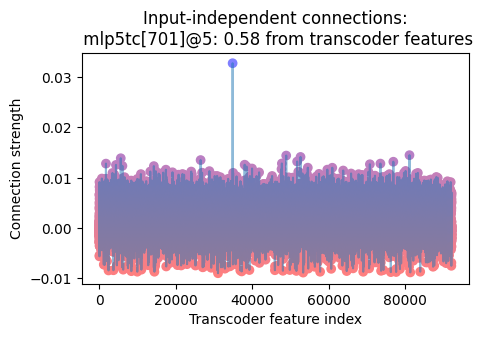

In [30]:
display_transcoder_pullback_features(model, all_paths[0][1][0], transcoders[4], k=5)

mlp5tc[701]@5: 0.58


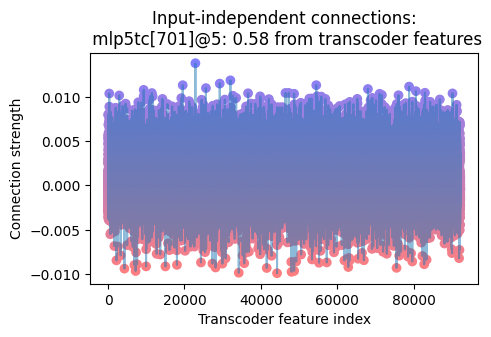

In [31]:
print(all_paths[0][4][0])
display_transcoder_pullback_features(model, all_paths[0][4][0], transcoders[2], k=5)

These connections are rather dense -- a large number of MLP2 transcoder features might cause the MLP8 transcoder feature to activate. But notice: the feature that we saw earlier, `mlp2tc[15119]`, is present among the top five most important input-independent features.

#### Investigating pullback features

What does `mlp2tc[15119]` activate on? And what about the other ones?

In [34]:
# get scores for feature mlp2tc[7620]
cur_scores = get_feature_scores(model, transcoders[2], owt_tokens_torch[:128*100], 7620, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

  6%|▌         | 6/100 [00:03<00:51,  1.83it/s]


KeyboardInterrupt: 

`mlp2tc[7620]` fires highest on `g` after a number (as in "grams"), but also fires on other lowercase letters after numbers.

In [ ]:
# get scores for mlp2tc[22821]
cur_scores = get_feature_scores(model, transcoders[2], owt_tokens_torch[:128*100], 22821, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

`mlp2tc[22821]` fires on capital letters in acronyms, particularly towards the end.

In [ ]:
# get scores for mlp2tc[14119]
cur_scores = get_feature_scores(model, transcoders[2], owt_tokens_torch[:128*100], 14119, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

`mlp2tc[14119]` fires on two-capital-letter tokens.

In [ ]:
# get scores for mlp2tc[15119]
cur_scores = get_feature_scores(model, transcoders[2], owt_tokens_torch[:128*100], 15119, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

`mlp2tc[15119]` fires on a single capital letter (particularly `G`) after a single digit.

In [ ]:
# get scores for mlp2tc[18482]
cur_scores = get_feature_scores(model, transcoders[2], owt_tokens_torch[:128*100], 18482, batch_size=128, use_raw_scores=False)
display_activating_examples_dash(model, owt_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

`mlp2tc[18482]` is the only one that doesn't fit the pattern -- this fires on words related to climate change and carbon.

## Input-dependent feature connections

Pullbacks and de-embeddings are useful for helping us understand general principles regarding what earlier-layer features cause a later-layer feature to fire. But these input-independent feature connections can be extremely dense. Luckily, on a given input, because of the sparsity of transcoders, the lower-layer features that are responsible for the higher-layer feature firing are extremely sparse! This means that looking at input-*dependent* feature connections can be very interpretable.

Note the difference between the semantics of input-independent feature connections (pullbacks) and input-dependent feature connections:
* For pullbacks, an earlier-layer feature's importance is determined by how much more the later-layer feature fires *if* the earlier-layer feature fires one unit more.
  * This is the gradient of the later-layer feature activation with respect to the earlier-layer transcoder's feature activation vector.
  * If $W_{dec}$ is the decoder matrix for the earlier-layer transcoder, and $n$ is the later-layer feature's encoder vector, then this gradient can be written as $W_{dec}^T n$.
* For input-**dependent** feature connections, an earlier-layer feature's importance is determined by how much the later-layer feature's activation is due to the earlier-layer feature's *activation on the given input*.
  * In particular, this is the pointwise product of the earlier-layer feature activation vector with the gradient of the later-layer feature activation w.r.t. the earlier-layer feature activation vector.
    * This means that input-dependent feature connections are an example of an "input-times-gradient" attribution method, which has previously seen use in computer vision settings.
  * If $W_{dec}$ is the decoder matrix for the earlier-layer transcoder, $n$ is the later-layer feature's encoder vector, and $z$ is the vector of earlier-layer feature activations, then this can be written as $(W_{dec}^T n) \odot z$.
    * Notice how input-dependent feature connections factor into two parts: a constant term $(W_{dec}^T n)$, and the earlier-layer transcoder feature activations $z$. To the extent that transcoder features are interpretable, both of these terms are interpretable. This is an example of the sort of analysis that makes us bullish on transcoders for circuit analysis: they make nonlinear feature attribution interpretable.
  * Why is this a reasonable way to define input-dependent feature connections? Well, the activation of the later-layer feature is given by $\operatorname{ReLU}(\left(W_{dec}^T n\right)^T z)$. If we denote the $i$-th component of $W_{dec}^T n$ as $\left(W_{dec}^T n\right)_i$, and the $i$-th component $z$ as $z_i$, then this can be written as $\operatorname{ReLU}(\left(W_{dec}^T n\right)_1 z_1 + \cdots + \left(W_{dec}^T n\right)_i z_i + \cdots)$. Thus, if we ignore the ReLU, then the contribution of earlier-layer feature $i$ to this later-layer feature activation is given by $\left(W_{dec}^T n\right)_i z_i$. Collecting all these terms into a single vector yields $(W_{dec}^T n) \odot z$.

To find input-dependent feature connections, you can also use `display_transcoder_pullback_features()` -- the same function from before -- but with some additional arguments.

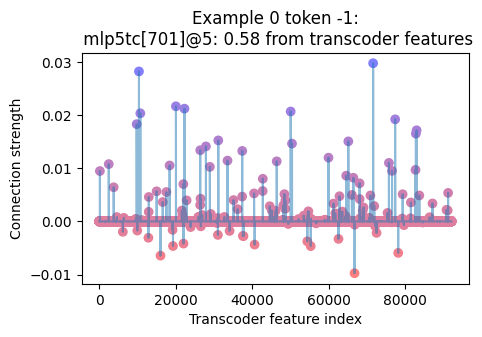

In [32]:
display_transcoder_pullback_features(model, all_paths[0][4][0], transcoders[2], k=10,
    input_tokens=model.tokenizer(prompt, return_tensors='pt').input_ids, # pass our prompt as input
    input_example=0, # our prompt has only one example in it
    input_token_idx=-1 # look at the last token in our prompt
)

Look at that: in comparison with our previous input-independent attributions, the input-dependent attributions are far more sparse and far more digestible! Also, note that the top input-dependent feature, Feature 15119, was among the top input-independent features that we found earlier.

#### Comparing pullbacks with mean input-dependent feature connections

On any given input, the most important input-dependent features are likely different from the most important pullback features (input-independent). But what about the *average* behavior of input-dependent features? To what extent do the top features according to pullbacks correspond with the top features according to input-dependent connections *when averaged over a bunch of different examples*?

In this experiment, we'll look at the mean importance of MLP2 transcoder features for our MLP8 transcoder feature across a number of dataset examples (in particular: on dataset examples where the MLP8 transcoder feature activates more than the 20th percentile). Then, for varying values of $k$, we'll look at the proportion of top $k$ input-independent pullback features that are also among the top $k$ mean input-dependent features.

In [33]:
scores = get_feature_scores(model, transcoders[5], owt_tokens_torch, feature_idx, batch_size=128, use_raw_scores=False)

100%|██████████| 256/256 [02:00<00:00,  2.13it/s]


In [34]:
# get_mean_ixg() is a function from transcoder_circuits.circuit_analysis
#  that gets the mean vector of input-dependent connections (input-times-gradient) over a set of examples
mean_ixg = get_mean_ixg(model, owt_tokens_torch, transcoders[5], feature_idx, transcoders[2],
    token_idxs=np.stack(np.unravel_index( # get all tokens where the feature's activation is more than the 20th percentile
        np.arange(len(scores.reshape(-1)))[scores.reshape(-1) > np.percentile(scores[scores > 0], 20)], scores.shape
    )).T,
)

# compare to input-independent pullback
pullback = transcoders[2].W_dec @ feature_vector.vector

# compute number of features that are in top k features according to both pullback and mean ixg
def _num_common_features(k): 
    a = set(utils.to_numpy(torch.topk(torch.from_numpy(mean_ixg), k=k).indices))
    b = set(utils.to_numpy(torch.topk(pullback, k=k).indices))
    return len(a.intersection(b))/len(a)

  0%|          | 0/2777 [00:00<?, ?it/s]

100%|██████████| 2777/2777 [03:52<00:00, 11.95it/s]


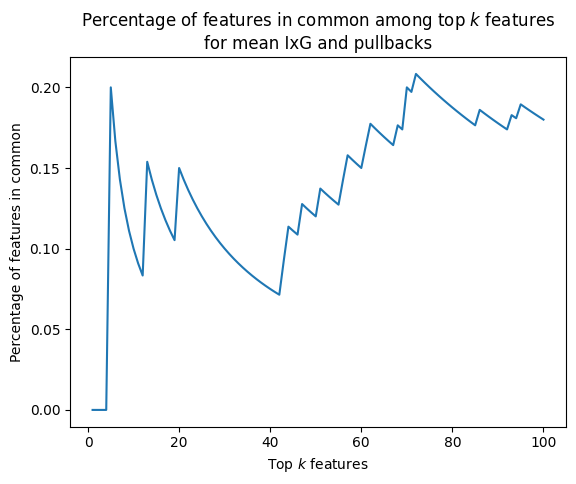

In [35]:
xs = np.arange(1,101)
ys = [_num_common_features(k) for k in xs]
plt.plot(xs, ys)
plt.xlabel("Top $k$ features")
plt.ylabel("Percentage of features in common")
plt.title("Percentage of features in common among top $k$ features\nfor mean IxG and pullbacks")
plt.show()

There's a decent overlap. In particular, here are the overlaps at specific values of $k$:

In [36]:
print(f"Percentage of common features in top 10: {_num_common_features(10) * 100:.2f}%")
print(f"Percentage of common features in top 20: {_num_common_features(20) * 100:.2f}%")
print(f"Percentage of common features in top 50: {_num_common_features(50) * 100 :.2f}%")

Percentage of common features in top 10: 10.00%
Percentage of common features in top 20: 15.00%
Percentage of common features in top 50: 12.00%


Note that for other features, the pullback is an even better estimator of the mean input-dependent feature strengths. Let's repeat this experiment, but looking at the importance of MLP0 transcoder features on MLP5 transcoder feature 12450. (This is an example that came up in one of our case studies.)

In [37]:
my_feature = make_sae_feature_vector(transcoders[5], 12450, use_encoder=True, token=-1)
scores = get_feature_scores(model, transcoders[5], owt_tokens_torch, 12450, batch_size=128, use_raw_scores=False)

 13%|█▎        | 34/256 [00:16<01:46,  2.08it/s]


KeyboardInterrupt: 

In [ ]:
display_transcoder_pullback_features(model, make_sae_feature_vector(transcoders[5], 12450), transcoders[0], k=5)

In comparison with the input-independent pullback from earlier, we can see that this pullback is a bit more sparse.

One potential piece of intuition for why this happens: some features might activate on a wider variety of inputs than others. For instance, a hypothetical "noun" feature might activate on a whole lot of earlier-layer features, while a "punctuation in the context of math" feature would fire on a smaller number of features. In this (hypothetical) example, the former feature might display a denser pullback than the latter.

Now, let's repeat the experiment comparing this pullback to the mean input-times-gradient vector.

In [ ]:
mean_ixg = get_mean_ixg(model, owt_tokens_torch, transcoders[5], 12450, transcoders[0],
    token_idxs=np.stack(np.unravel_index( # get all tokens where the feature's activation is more than the 20th percentile
        np.arange(len(scores.reshape(-1)))[scores.reshape(-1) > np.percentile(scores[scores > 0], 20)], scores.shape
    )).T,
)

# compare to input-independent pullback
pullback = transcoders[0].W_dec @ my_feature.vector

xs = np.arange(1,101)
ys = [_num_common_features(k) for k in xs]
plt.plot(xs, ys)
plt.xlabel("Top $k$ features")
plt.ylabel("Percentage of features in common")
plt.title("Percentage of features in common among top $k$ features\nfor mean IxG and pullbacks")
plt.show()

In [ ]:
print(f"Percentage of common features in top 10: {_num_common_features(10) * 100:.2f}%")
print(f"Percentage of common features in top 20: {_num_common_features(20) * 100:.2f}%")
print(f"Percentage of common features in top 50: {_num_common_features(50) * 100 :.2f}%")

In this case, there's far more overlap between the top MLP0 features according to the input-independent pullback and the top MLP0 features according to the mean input-dependent input-times-gradient.

# Where to go from here?

At this point, we've introduced just about all of our tools for analyzing transcoder circuits. The next step is to start using them! We've provided a number of notebooks in this directory containing actual case studies that we carried out of various features using these transcoder circuit tools. By referencing these case studies in conjunction with this introductory notebook, you should hopefully get a feel for how to use the transcoder circuit tools to do your own analysis.

Have fun interpreting!